In [1]:
import zipfile
import pandas as pd
import numpy as np
from PIL import Image
import io
# List of paths to your zip files 
# The four zip files should be:
# 1. inpainting.zip
# 2. insight.zip
# 3. text2img.zip
# 4. wiki.zip (contains real images)

#Make sure you do not commit the data to the repository
#Also make sure to not upload your paths to the repository


zip_paths = [
    '../mle_group_6_data/inpainting.zip',
    '../mle_group_6_data/insight.zip',
    '../mle_group_6_data/text2img.zip',
    '../mle_group_6_data/wiki.zip'
]




# Function to add image data to a DataFrame from multiple zip files
def create_image_dataframe(zip_paths, base_num_images_per_zip=1000):
    # List to store image data
    data = []

    # Process each zip file
    for zip_path in zip_paths:
        print(f"Processing zip file: {zip_path}")  # Print current zip file being processed

        # Determine number of images to process based on zip file name
        if 'wiki.zip' in zip_path:
            num_images_per_zip = base_num_images_per_zip * 3
        else:
            num_images_per_zip = base_num_images_per_zip

        with zipfile.ZipFile(zip_path, 'r') as z:
            image_count = 0  # Initialize image counter for the current zip file

            # Iterate over each item in the zip
            for file in sorted(z.namelist()):
                if file.endswith(('.png', '.jpg', '.jpeg')) and '/' in file:
                    # Read the image
                    image_data = z.read(file)
                    image = Image.open(io.BytesIO(image_data))

                    # Convert image to grayscale and resize
                    image = image.convert('RGB').resize((128, 128), Image.LANCZOS)
                    img_array = np.array(image)

                    # Determine if the image is a deepfake or not based on the zip file
                    is_deep_fake = not zip_path.endswith('wiki.zip')

                    # Append image information to the list
                    data.append({
                        'Zip Folder': zip_path,
                        'Image Path': file,
                        'Is DeepFake': is_deep_fake,
                        'Image Data': img_array.flatten()  # Flatten the array
                    })

                    image_count += 1
                    if image_count >= num_images_per_zip:
                        break  # Stop processing if the image limit is reached
                else:
                    print(file)

    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

# Call the function and store the DataFrame
df_images = create_image_dataframe(zip_paths)

C:\Users\shume\AppData\Local\Temp\ipykernel_19724\4121480383.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Processing zip file: ../mle_group_6_data/inpainting.zip
inpainting/
inpainting/00/
inpainting/01/
inpainting/02/
inpainting/03/
Processing zip file: ../mle_group_6_data/insight.zip
insight/
insight/00/
insight/01/
insight/02/
insight/03/
Processing zip file: ../mle_group_6_data/text2img.zip
text2img/
text2img/00/
text2img/01/
text2img/02/
text2img/03/
Processing zip file: ../mle_group_6_data/wiki.zip
wiki/
wiki/00/
wiki/01/
wiki/02/
wiki/03/
wiki/04/
wiki/05/
wiki/06/
wiki/07/
wiki/08/
wiki/09/
wiki/10/


In [2]:
image_counts = df_images['Zip Folder'].value_counts()
dataset_size = 0
for count in image_counts:
    dataset_size = dataset_size + count
print (dataset_size)
print("\nNumber of images from each zip folder:")
print(image_counts)

6000

Number of images from each zip folder:
Zip Folder
../mle_group_6_data/wiki.zip          3000
../mle_group_6_data/inpainting.zip    1000
../mle_group_6_data/insight.zip       1000
../mle_group_6_data/text2img.zip      1000
Name: count, dtype: int64


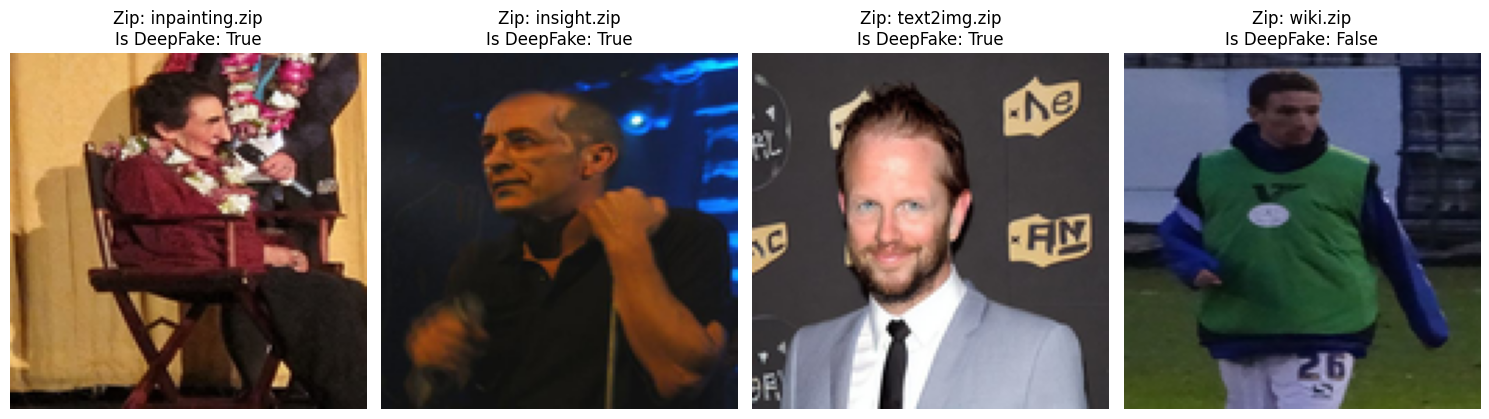

In [3]:
import matplotlib.pyplot as plt
import random

def display_random_images_from_each_zip(df_images):
    # Find unique zip folders
    unique_zip_folders = df_images['Zip Folder'].unique()

    fig, axes = plt.subplots(1, len(unique_zip_folders), figsize=(15, 5))

    # Loop through each unique zip folder
    for i, zip_folder in enumerate(unique_zip_folders):
        # Filter the DataFrame for images only from the current zip folder
        folder_images = df_images[df_images['Zip Folder'] == zip_folder]
        
        # Select a random image from this folder
        random_index = random.randint(0, len(folder_images) - 1)
        image_row = folder_images.iloc[random_index]
        image_data = image_row['Image Data'].reshape(128, 128, 3)  # Reshape the flattened array back to 128x128
        is_deep_fake = image_row['Is DeepFake']  # Retrieve the 'Is DeepFake' status correctly from the row

        # Plot the image
        ax = axes[i] if len(unique_zip_folders) > 1 else axes
        ax.imshow(image_data, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Zip: {zip_folder.split('/')[-1]}\nIs DeepFake: {is_deep_fake}")


    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_random_images_from_each_zip(df_images)


In [5]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

def prepare_data_for_cnn(df_images):
    # Convert flattened images to 2D shape and expand dimensions to include the channel
    images = np.stack(df_images['Image Data'].apply(lambda x: np.reshape(x, (128, 128, 3))))

    # Normalize the images to have values between 0 and 1
    #images = images.astype('float32') / 255.0

    # Extract labels and convert them to integer format
    labels = df_images['Is DeepFake'].values.astype('int')

    return images, labels

# Assuming df_images is your DataFrame containing the required image data
images, labels = prepare_data_for_cnn(df_images)

# Shuffle the data to ensure randomness before stratified splitting
indices = np.arange(len(labels))
np.random.shuffle(indices)
images_shuffled = images[indices]
labels_shuffled = labels[indices]

# Split data into train+val and test using stratified sampling to maintain class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(images_shuffled, labels_shuffled, test_size=0.1, stratify=labels_shuffled, random_state=42)

# Split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, stratify=y_train_val, random_state=42)  # 0.111 is roughly 10% of 0.9

# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32)
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

def count_classes(labels):
    # Count classes in the label array
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

# Print dataset cardinalities and class distribution
print("Training set size:", len(y_train), "Class distribution:", count_classes(y_train))
print("Test set size:", len(y_test), "Class distribution:", count_classes(y_test))
print("Validation set size:", len(y_val), "Class distribution:", count_classes(y_val))

# Take one batch from the dataset and print shapes
for images_batch, labels_batch in train_dataset.take(1):
    print("Images shape:", images_batch.shape)  # Expected shape: (batch_size, 128, 128, 3)
    print("Labels shape:", labels_batch.shape)  # Expected shape: (batch_size,)


Training set size: 4800 Class distribution: {0: 2400, 1: 2400}
Test set size: 600 Class distribution: {0: 300, 1: 300}
Validation set size: 600 Class distribution: {0: 300, 1: 300}
Images shape: (32, 128, 128, 3)
Labels shape: (32,)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import MobileNetV2
#highest accuracy so far is 0.9617 

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False
l2_reg = 0.01

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg))
])

# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.5481 - loss: 2.1229 - val_accuracy: 0.5600 - val_loss: 1.0374
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.5763 - loss: 0.9685 - val_accuracy: 0.6200 - val_loss: 0.8286
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.5755 - loss: 0.8156 - val_accuracy: 0.6033 - val_loss: 0.7504
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.5884 - loss: 0.7463 - val_accuracy: 0.6150 - val_loss: 0.7160
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.6056 - loss: 0.7113 - val_accuracy: 0.6117 - val_loss: 0.6907
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.6004 - loss: 0.7028 - val_accuracy: 0.6267 - val_loss: 0.6894
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.6154 - loss: 0.6840 - val_accuracy: 0.6200 - val_loss: 0.6789
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.5967 - loss: 0.6852 -

In [47]:
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

print("Generate predictions for 3 samples")
predictions = model.predict(test_dataset.take(3))
print("predictions shape:", predictions.shape)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.6341 - loss: 0.6538
test loss, test acc: [0.6631521582603455, 0.6133333444595337]
Generate predictions for 3 samples
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
predictions shape: (96, 1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step


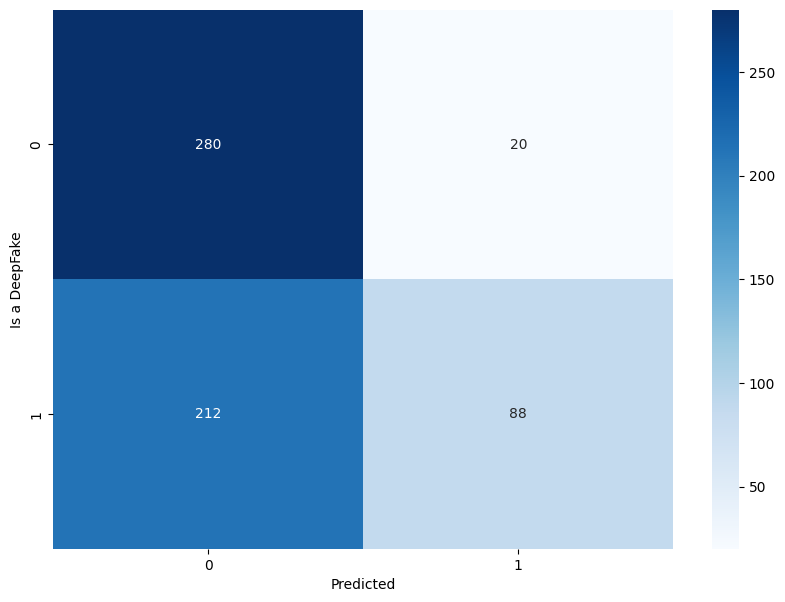

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Get the predicted labels as probabilities
y_pred_prob = model.predict(test_dataset)

# Convert the probabilities into class labels
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Is a DeepFake')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 10/1000 [00:01<02:14,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  2%|▏         | 20/1000 [00:01<01:01, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  3%|▎         | 30/1000 [00:01<00:37, 25.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  4%|▍         | 40/1000 [00:01<00:28, 34.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  5%|▌         | 50/1000 [00:01<00:21, 44.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  6%|▌         | 60/1000 [00:01<00:17, 54.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  7%|▋         | 70/1000 [00:02<00:14, 62.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  8%|▊         | 80/1000 [00:02<00:13, 66.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  9%|▉         | 90/1000 [00:02<00:12, 71.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 10%|█         | 100/1000 [00:02<00:12, 71.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 11%|█         | 110/1000 [00:02<00:11, 75.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 13%|█▎        | 130/1000 [00:02<00:10, 86.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 14%|█▍        | 144/1000 [00:02<00:08, 98.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 16%|█▌        | 155/1000 [00:02<00:08, 100.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 17%|█▋        | 166/1000 [00:03<00:09, 87.75it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 18%|█▊        | 176/1000 [00:03<00:09, 88.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 190/1000 [00:03<00:09, 82.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 20%|██        | 200/1000 [00:03<00:09, 83.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 21%|██        | 210/1000 [00:03<00:09, 83.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 22%|██▏       | 220/1000 [00:03<00:09, 86.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 23%|██▎       | 230/1000 [00:03<00:08, 89.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 24%|██▍       | 240/1000 [00:03<00:08, 90.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▌       | 250/1000 [00:04<00:08, 90.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 262/1000 [00:04<00:07, 98.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 279/1000 [00:04<00:06, 118.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 29%|██▉       | 292/1000 [00:04<00:07, 90.89it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|███       | 303/1000 [00:04<00:08, 85.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 320/1000 [00:04<00:07, 85.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|███▍      | 338/1000 [00:04<00:06, 105.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 35%|███▌      | 350/1000 [00:05<00:07, 85.75it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 36%|███▌      | 360/1000 [00:05<00:07, 86.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 371/1000 [00:05<00:06, 91.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 381/1000 [00:05<00:06, 92.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 39%|███▉      | 391/1000 [00:05<00:06, 90.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|████      | 403/1000 [00:05<00:06, 98.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 420/1000 [00:05<00:06, 93.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|████▎     | 430/1000 [00:05<00:06, 94.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 44%|████▍     | 440/1000 [00:06<00:06, 81.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▌     | 450/1000 [00:06<00:06, 84.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▌     | 461/1000 [00:06<00:05, 90.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 47%|████▋     | 471/1000 [00:06<00:05, 92.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 48%|████▊     | 481/1000 [00:06<00:05, 93.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 49%|████▉     | 491/1000 [00:06<00:05, 95.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 50%|█████     | 501/1000 [00:06<00:05, 89.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████     | 511/1000 [00:06<00:05, 89.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 522/1000 [00:07<00:05, 95.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 53%|█████▎    | 532/1000 [00:07<00:05, 91.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▍    | 542/1000 [00:07<00:05, 89.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▌    | 552/1000 [00:07<00:04, 90.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 562/1000 [00:07<00:04, 92.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 57%|█████▋    | 572/1000 [00:07<00:05, 77.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 58%|█████▊    | 581/1000 [00:07<00:05, 75.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|█████▉    | 590/1000 [00:07<00:05, 78.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|██████    | 600/1000 [00:07<00:04, 83.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 620/1000 [00:08<00:04, 93.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 640/1000 [00:08<00:03, 97.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 660/1000 [00:08<00:03, 101.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 680/1000 [00:08<00:03, 102.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|██████▉   | 695/1000 [00:08<00:02, 112.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 71%|███████   | 707/1000 [00:08<00:02, 105.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 718/1000 [00:09<00:02, 106.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 729/1000 [00:09<00:02, 104.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 80.00it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▌  | 750/1000 [00:09<00:03, 82.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 76%|███████▌  | 760/1000 [00:09<00:02, 83.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 771/1000 [00:09<00:02, 89.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 781/1000 [00:09<00:02, 90.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 79%|███████▉  | 791/1000 [00:09<00:02, 92.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 80%|████████  | 801/1000 [00:10<00:02, 93.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 81%|████████  | 811/1000 [00:10<00:02, 92.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 82%|████████▏ | 821/1000 [00:10<00:01, 92.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 83%|████████▎ | 831/1000 [00:10<00:02, 81.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 84%|████████▍ | 840/1000 [00:10<00:01, 81.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 85.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 87.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 87%|████████▋ | 870/1000 [00:10<00:01, 88.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 880/1000 [00:10<00:01, 91.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 88.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████ | 910/1000 [00:11<00:00, 91.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 920/1000 [00:11<00:00, 92.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 930/1000 [00:11<00:00, 94.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 94%|█████████▍| 940/1000 [00:11<00:00, 92.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▌| 950/1000 [00:11<00:00, 93.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 968/1000 [00:11<00:00, 117.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 980/1000 [00:11<00:00, 95.28it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 991/1000 [00:12<00:00, 96.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


100%|██████████| 1000/1000 [00:12<00:00, 81.89it/s]


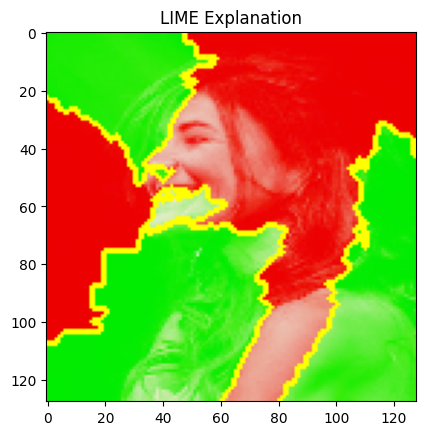

In [19]:
# import lime
# from lime import lime_image
# from tensorflow.keras.preprocessing import image
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt

# # Function to preprocess the image to be model-ready
# def preprocess_image(img_path, target_size):
#     img = image.load_img(img_path, target_size=target_size)
#     img_array = image.img_to_array(img)
#     img_array_expanded_dims = np.expand_dims(img_array, axis=0)
#     return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)

# # Prepare the image
# img_path = "23300_1962-06-19_2011.jpg"
# processed_image = preprocess_image(img_path, (128, 128))

# # Create a Lime Image Explainer
# explainer = lime_image.LimeImageExplainer()

# # Define a prediction function
# def model_prediction(data):
#     pred = model.predict(data)
#     # For binary classification, Lime needs binary probabilities
#     return np.hstack((1-pred, pred))

# # Explain an image prediction
# explanation = explainer.explain_instance(processed_image[0], 
#                                          model_prediction, # prediction function
#                                          top_labels=1, 
#                                          hide_color=0, 
#                                          num_samples=1000) # number of images that will be sent to classification function

# # Display the image and the mask on the explanation
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
# plt.title('LIME Explanation')
# plt.show()
